In [1]:
import sys
assert sys.version_info >= (3, 5)

import numpy as np
import pandas as pd
import os

import sklearn
from sklearn.preprocessing import OneHotEncoder
assert sklearn.__version__ >= "0.20"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import model_from_json
assert tf.__version__ >= "2.0"

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from functools import partial

import winsound
import time

In [2]:
proj_dir = r"C:\Users\19673418\Desktop\ADA874\Kaggle Competition\Digit Recognizer"

def save_fig(fig_id, tight_layout = True):
    path = os.path.join(proj_dir, "Images", fig_id + ".png")
    print("Saving figure", fig_id, "...")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = 'png', dpi = 300)
    print("Figure saved!")

In [3]:
def plot_digit(x_data, dim):
    digit = x_data.reshape(dim, dim)
    plt.imshow(digit, cmap = mpl.cm.binary, interpolation = "nearest")
    plt.axis("off")

In [4]:
def plot_digits(x_data, dim, dig_per_row = 10, **options):
    dig_per_row = min(len(x_data), dig_per_row)
    digits = [digit.reshape(dim, dim) for digit in x_data]
    n_rows = (len(x_data) - 1) // dig_per_row + 1
    row_dig = []
    n_empty = n_rows * dig_per_row - len(x_data)
    digits.append(np.zeros((dim, dim*n_empty)))
    for row in range(n_rows):
        r_dig = x_data[row * dig_per_row: (row + 1)*dig_per_row]
        row_dig.append(np.concatenate(r_dig, axis = 1))
    dig = np.concatenate(row_dig, axis = 0)
    plt.imshow(dig, cmap = mpl.cm.binary, interpolation = "nearest", **options)
    plt.axis("off")

In [5]:
f = 2000
t = 500

In [6]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [9]:
def prep_x(x_data):
    x_mean = x_data.mean(axis = 0, keepdims = True)
    x_std = x_data.std(axis = 0, keepdims = True) + 1e-7
    x_data = (x_data - x_mean)/x_std
    x_data = x_data[..., np.newaxis]
    return x_data

Saving figure Example_Digits ...
Figure saved!


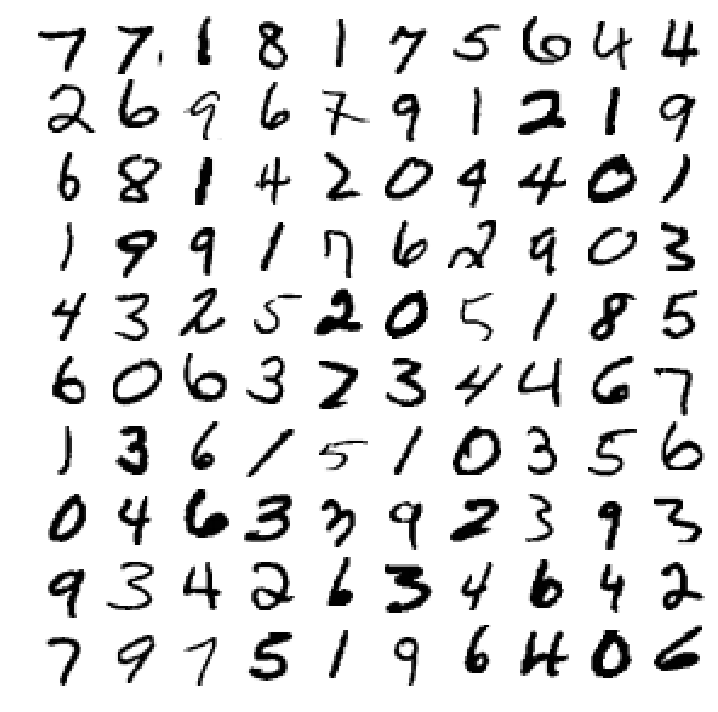

In [10]:
x_train = train_data.iloc[:, 1:]
x_train = x_train.values.astype(np.float32).reshape((x_train.shape[0], 28, 28)) / 255
x_valid, x_train = x_train[:4200], x_train[4200:]

plt.figure(figsize = (10, 10))
plot_digits(x_train[0:100], 28, dig_per_row = 10)
save_fig("Example_Digits")

y_train = train_data.iloc[:, 0]
y_train = y_train.values.astype(np.float32)
y_valid, y_train = y_train[:4200], y_train[4200:]

x_test = test_data.iloc[:, :]
x_test = test_data.values.astype(np.float32).reshape((x_test.shape[0], 28, 28)) / 255

x_train = prep_x(x_train)
x_valid = prep_x(x_valid)
x_test = prep_x(x_test)

In [11]:
print('x_train:')
print('Shape:      ', x_train.shape)
print('Datatype:   ', x_train.dtype)
print('Size:       ', x_train.size)
print('Dimensions: ', x_train.ndim)

x_train:
Shape:       (37800, 28, 28, 1)
Datatype:    float32
Size:        29635200
Dimensions:  4


x_test:
Shape:  (28000, 28, 28, 1)
Datatype:  float32
Size:  21952000
Dimensions:  4
Saving figure Example_Normalized_Digit ...
Figure saved!


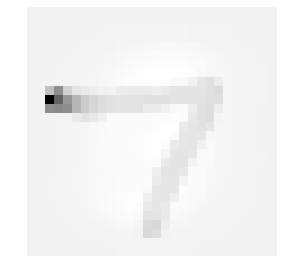

In [12]:
print('x_test:')
print('Shape: ', x_test.shape)
print('Datatype: ', x_test.dtype)
print('Size: ', x_test.size)
print('Dimensions: ', x_test.ndim)
plot_digit(x_train[0], 28)
save_fig("Example_Normalized_Digit")

In [13]:
def_conv2d = partial(keras.layers.Conv2D, kernel_size = 3, activation = 'relu', padding = "SAME")

In [14]:
cnn = keras.models.Sequential([
    def_conv2d(filters = 64, kernel_size = 7, input_shape = [28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size = 2),
    def_conv2d(filters = 128),
    def_conv2d(filters = 128),
    keras.layers.MaxPooling2D(pool_size = 2),
    def_conv2d(filters = 256),
    def_conv2d(filters = 256),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units = 64, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units = 10, activation = 'softmax')
])

In [15]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

In [16]:
#cnn.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
#history = cnn.fit(x_train, y_train, epochs = 10, validation_data = [x_valid, y_valid])

#cnn_json = cnn.to_json()
#with open("cnn.json", "w") as json_file:
#    json_file.write(cnn_json)
    
#cnn.save_weights("cnn.h5")
#print("CNN has been saved.")

#winsound.Beep(f, t)

In [17]:
json_file = open('cnn.json', 'r')
cnn_load_json = json_file.read()
json_file.close()
cnn_load = model_from_json(cnn_load_json)
cnn_load.load_weights("cnn.h5")
print("CNN has been loaded.")

cnn_load.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
y_pred_cnn = cnn_load.predict(x_test)
winsound.Beep(f, t)

CNN has been loaded.


In [18]:
print('y_pred_cnn:')
print('Shape: ', y_pred_cnn.shape)
print('Datatype: ', y_pred_cnn.dtype)
print('Size: ', y_pred_cnn.size)
print('Dimensions: ', y_pred_cnn.ndim)
y_pred_cnn[0:3]

y_pred_cnn:
Shape:  (28000, 10)
Datatype:  float32
Size:  280000
Dimensions:  2


array([[0.0000000e+00, 8.9150226e-35, 1.0000000e+00, 6.1040491e-30,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.8151322e-34,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.0387188e-35, 1.4622281e-33, 1.4577692e-30,
        9.5489438e-32, 2.3885880e-27, 2.8687649e-17, 0.0000000e+00,
        1.8747126e-24, 6.1232959e-28],
       [1.9546301e-18, 1.1088184e-18, 8.9207318e-18, 2.0381571e-11,
        1.7236451e-06, 2.6558950e-12, 1.2597572e-19, 1.3845497e-11,
        7.8292851e-11, 9.9999833e-01]], dtype=float32)

In [19]:
y_pred_cnn_sub = np.argmax(y_pred_cnn, axis = 1)
y_pred_cnn_sub

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [20]:
y_pred_i = np.arange(1, len(y_pred_cnn_sub) + 1)

In [21]:
submission = pd.DataFrame(y_pred_i)
submission = pd.concat([submission, pd.DataFrame(y_pred_cnn_sub)], axis = 1)
submission.columns = ["ImageId", "Label"]
submission.to_csv("sub_cnn_01.csv", index = False)

In [22]:
def prep_x(x_data):
    x_data = x_data[..., np.newaxis]
    return x_data

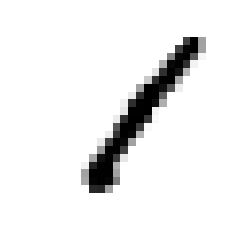

In [23]:
x_train = train_data.iloc[:, 1:]
x_train = x_train.values.astype(np.float32).reshape((x_train.shape[0], 28, 28)) / 255

plot_digit(x_train[0], 28)

y_train = train_data.iloc[:, 0]
y_train = y_train.values.astype(np.float32)

x_test = test_data.iloc[:, :]
x_test = test_data.values.astype(np.float32).reshape((x_test.shape[0], 28, 28))

x_train = prep_x(x_train)
x_test = prep_x(x_test)

In [24]:
print('x_train:')
print('Shape:      ', x_train.shape)
print('Datatype:   ', x_train.dtype)
print('Size:       ', x_train.size)
print('Dimensions: ', x_train.ndim)

x_train:
Shape:       (42000, 28, 28, 1)
Datatype:    float32
Size:        32928000
Dimensions:  4


In [25]:
ohe = OneHotEncoder(sparse = False, categories = 'auto')

y_train_ohe = ohe.fit_transform(y_train.reshape(-1, 1))

In [26]:
print('y_train_ohe:')
print('Shape:      ', y_train_ohe.shape)
print('Datatype:   ', y_train_ohe.dtype)
print('Size:       ', y_train_ohe.size)
print('Dimensions: ', y_train_ohe.ndim)

y_train_ohe:
Shape:       (42000, 10)
Datatype:    float64
Size:        420000
Dimensions:  2


In [27]:
ln5 = keras.models.Sequential([
    keras.layers.Conv2D(filters = 12, kernel_size = (5, 5), activation = 'relu', input_shape = (28, 28, 1)),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.Conv2D(filters = 25, kernel_size = (5, 5), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 180, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units = 100, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units = 10, activation = 'softmax'),
])

In [28]:
ln5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 12)        312       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 12)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 25)          7525      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 25)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 180)               72180     
_________________________________________________________________
dropout_2 (Dropout)          (None, 180)              

In [29]:
start = time.time()

ln5.compile(loss = "categorical_crossentropy", optimizer = "adamax", metrics = ["accuracy"])
history = ln5.fit(x_train, y_train_ohe, batch_size = 128, epochs = 75)

end = time.time()
print("LeNet-5 took %.3fs to train." %(end - start))

ln5_json = ln5.to_json()
with open("ln5.json", "w") as json_file:
    json_file.write(ln5_json)
    
ln5.save_weights("ln5.h5")
print("LeNet-5 has been saved.")

winsound.Beep(f, t)

Epoch 1/75
42000/42000 [==============================] - 13s 301us/sample - loss: 0.9014 - accuracy: 0.7068
Epoch 2/75
42000/42000 [==============================] - 12s 289us/sample - loss: 0.3197 - accuracy: 0.9048
Epoch 3/75
42000/42000 [==============================] - 12s 284us/sample - loss: 0.2256 - accuracy: 0.9340
Epoch 4/75
42000/42000 [==============================] - 12s 282us/sample - loss: 0.1871 - accuracy: 0.9470
Epoch 5/75
42000/42000 [==============================] - 12s 279us/sample - loss: 0.1577 - accuracy: 0.9565
Epoch 6/75
42000/42000 [==============================] - 11s 270us/sample - loss: 0.1378 - accuracy: 0.9611
Epoch 7/75
42000/42000 [==============================] - 12s 283us/sample - loss: 0.1277 - accuracy: 0.9643
Epoch 8/75
42000/42000 [==============================] - 12s 283us/sample - loss: 0.1195 - accuracy: 0.9662
Epoch 9/75
42000/42000 [==============================] - 12s 279us/sample - loss: 0.1069 - accuracy: 0.9702
Epoch 10/75
42000/4

42000/42000 [==============================] - 12s 285us/sample - loss: 0.0167 - accuracy: 0.9950
LeNet-5 took 911.159s to train.
LeNet-5 has been saved.


In [30]:
start = time.time()

json_file = open('ln5.json', 'r')
ln5_load_json = json_file.read()
json_file.close()
ln5_load = model_from_json(ln5_load_json)
ln5_load.load_weights("ln5.h5")
print("LeNet-5 has been loaded.")

ln5_load.compile(loss = "categorical_crossentropy", optimizer = "adamax", metrics = ["accuracy"])
y_pred_ln5 = ln5_load.predict(x_test)

end = time.time()
print("Predictions for the test set have been made in %.3fs." %(end - start))
winsound.Beep(f, t)

LeNet-5 has been loaded.
Predictions for the test set have been made in 3.259s.


In [31]:
print('y_pred_ln5:')
print('Shape: ', y_pred_ln5.shape)
print('Datatype: ', y_pred_ln5.dtype)
print('Size: ', y_pred_ln5.size)
print('Dimensions: ', y_pred_ln5.ndim)
y_pred_ln5[0:3]

y_pred_ln5:
Shape:  (28000, 10)
Datatype:  float32
Size:  280000
Dimensions:  2


array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [32]:
y_pred_ln5_sub = np.argmax(y_pred_ln5, axis = 1)
y_pred_ln5_sub

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [33]:
submission = pd.DataFrame(y_pred_i)
submission = pd.concat([submission, pd.DataFrame(y_pred_ln5_sub)], axis = 1)
submission.columns = ["ImageId", "Label"]
submission.to_csv("sub_ln5_01.csv", index = False)